# Google Colab setup with Google Drive folder

This notebook provides the code you need to set up Google Colab to run and import files from within a Google Drive folder.

This will allow you to upload assignment code to your Google Drive and then run the code on Google Colab machines (with free GPUs if needed). 

You will need to create a folder in your Google Drive to hold your assignments and you will need to open Colaboratory within this folder before running the set up code (check the link above to see how).

Note: this use of Google Drive is optional, and you could also just manually copy the data into your colab runtime. Keep in mind, this won't be persistent though, and you will have to download your models / plots before the runtime shuts down.

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder).

In [2]:
import os
if not os.path.exists("/content/gdrive/MyDrive/CS543/MP4"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")
os.chdir("/content/gdrive/MyDrive/CS543/MP4")

In [3]:
!ls # Check if this is your MP4 folder

CS543_MP4_part1_starter_code.ipynb  README.md
CS543_MP4_part2_starter_code.ipynb  vis_deeplabv3_resnet18.png
data				    vis_gt.png
fashion-mnist.png		    vis_resnet18_dilate.png
__MACOSX			    vis_resnet18.png
mp4_q1_plot.png			    vis_trainset.pdf
Q1_label_predictions.npy


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [4]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Make sure that pytorch is installed and works with GPU:

In [5]:
import torch
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [6]:
torch.cuda.is_available()

True

In [7]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)

TOTAL_CLASSES = 10
class FashionMNISTTest(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None):
        super(FashionMNISTTest, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'fashion_secret_test_data.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 3
        assert images.shape[0] == 2000
        assert images.shape[1] == 28
        assert images.shape[2] == 28
        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if is_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(Variable(images))
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(list(predicted.cpu().numpy()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100 * correct / total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))
        
    return predictions


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized FashionMNIST training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .npy file for submission to Gradescope

In [8]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 30
# ---------
IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 64
PATH_TO_Fashion = "data/fashion/"
PATH_TO_Fashion_TEST = "data/fashion/"

1.**Loading FashionMNIST**

We will load the FashionMNIST dataset with builtin dataset loader from Torchvision.


In [9]:
# # The output of torchvision datasets are PILImage images of range [0, 1].
# # Using transforms.ToTensor(), transform them to Tensors of normalized range
# # [-1, 1].


# # <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# # make the data well conditioned (zero mean, std dev=1) for improved training.
# # <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# # to augment training data.
# # After your edits, make sure that test_transform should have the same data
# # normalization parameters as train_transform
# # You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# # ---------------------
# train_transform = transforms.Compose([
#     #transforms.RandomCrop(28, padding=2),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.2858,), (0.3204,))  # normalize to have zero mean and unit standard deviation
# ])

# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.2858,), (0.3204,))  # use the same normalization parameters as train_transform
# ])
# # ---------------------

# #DO NOT CHANGE any line below
# dataset = torchvision.datasets.FashionMNIST(root=PATH_TO_Fashion, train=True, download=True, transform=train_transform)
# print("dataset data shape: ", np.array(dataset.data).shape)
# print("dataset labels shape: ", np.array(dataset.targets).shape)

# # The 10 classes for FashionMNIST
# classes = dataset.classes
# # train dataset 55, 000 samples
# train_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset)-5000))
# # val dataset 5, 000 samples
# val_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset)-5000, len(dataset)))

# # check for Dataloader function: https://pytorch.org/docs/stable/data.html
# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
# valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)

In [10]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].


# <<TODO#1>> Use transforms.Normalize() with the right parameters to 
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
train_transform = transforms.Compose(
    [transforms.ToTensor()])
test_transform = transforms.Compose(
    [transforms.ToTensor()])
# ---------------------

#DO NOT CHANGE any line below
dataset = torchvision.datasets.FashionMNIST(root=PATH_TO_Fashion, train=True, download=True, transform=train_transform)
print("dataset data shape: ", np.array(dataset.data).shape)
print("dataset labels shape: ", np.array(dataset.targets).shape)

# The 10 classes for FashionMNIST
classes = dataset.classes
# train dataset 55, 000 samples
train_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset)-5000))
# val dataset 5, 000 samples
val_dataset = torch.utils.data.Subset(dataset, np.arange(len(dataset)-5000, len(dataset)))

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)

dataset data shape:  (60000, 28, 28)
dataset labels shape:  (60000,)


In [11]:
# mean = 0.
# std = 0.
# num_samples = 0.
# for data, _ in trainloader:
#     batch_size = data.size(0)
#     data = data.view(batch_size, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     num_samples += batch_size

# mean /= num_samples
# std /= num_samples

# print("Mean: ", mean)
# print("Std: ", std)

In [12]:
# mean = 0.
# std = 0.
# num_samples = 0.
# for data, _ in valloader:
#     batch_size = data.size(0)
#     data = data.view(batch_size, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     num_samples += batch_size

# mean /= num_samples
# std /= num_samples

# print("Mean: ", mean)
# print("Std: ", std)

In [13]:
#Load secret test set
#DO NOT CHANGE any line below
if not os.path.isfile(os.path.join("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4", PATH_TO_Fashion_TEST, "fashion_secret_test_data.npy")):
  %pip install -U gdown
  import gdown
  url = "https://drive.google.com/uc?id=130ssD7hrrDLqQHKVD3luD0tXTedWjC8j"
  output = os.path.join(PATH_TO_Fashion_TEST, "fashion_secret_test_data.npy")
  gdown.download(url, output, quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Downloading...
From: https://drive.google.com/uc?id=130ssD7hrrDLqQHKVD3luD0tXTedWjC8j
To: /content/gdrive/.shortcut-targets-by-id/1Semr4OmC4V4RNBav-0b0pMqLJsD3K0wb/CS543/MP4/data/fashion/fashion_secret_test_data.npy
100%|██████████| 1.57M/1.57M [00:00<00:00, 86.0MB/s]


In [14]:
test_img = np.load(os.path.join(PATH_TO_Fashion_TEST, "fashion_secret_test_data.npy"))
test_dataset = FashionMNISTTest(PATH_TO_Fashion_TEST, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

2.**Visualize FashionMNIST**

We will visualize some random images from the FashionMNIST dataset.

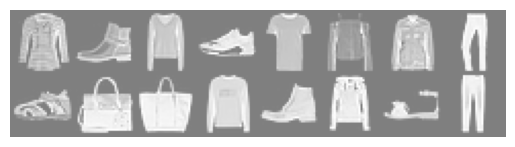

T-shirt/top Ankle boot Pullover Sneaker T-shirt/top Shirt  Coat Trouser Sandal   Bag   Bag Pullover Ankle boot  Coat Sandal Trouser


In [15]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

3.**Define a Convolution Neural Network**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 28 | 24 | 1 | 6 |
         | 2 | relu | - | 24 | 24 | 6 | 6 |
         | 3 | maxpool2d | 2 | 24 | 12 | 6 | 6 |
         | 4 | conv2d | 5 | 12 | 8 | 6 | 12 |
         | 5 | relu | - | 8 | 8 | 12 | 12 |
         | 6 | maxpool2d | 2 | 8 | 4 | 12 | 12 |
         | 7 | linear | - | 1 | 1 | 192 | 12 |
         | 8 | relu | - | 1 | 1 | 12 | 12 |
         | 9 | linear | - | 1 | 1 | 12 | 10 |

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=12)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=12, out_features=10)
        

    def forward(self, x):
        # TODO: define your model here
        x = self.relu1(self.conv1(x)) # Size([bs, 6, 24, 24])
        x = self.pool1(x)             # Size([bs, 6, 12, 12])
        
        # Second convolutional layer
        x = self.relu2(self.conv2(x)) # Size([bs, 12, 8, 8])
        x = self.pool2(x)             # Size([bs, 12, 4, 4])
        
        # Flatten for fully connected layers
        x = x.view(-1, 12 * 4 * 4)
        
        # Fully connected layers
        x = self.fc1(x)               # Size([bs, 192])
        x = self.relu3(x)             # size([bs, 12])
        x = self.fc2(x)               #size([bs, 10])
        return x

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=96)
        self.bn3 = nn.BatchNorm1d(12)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=96, out_features=48)
        self.fc3 = nn.Linear(48, 24)
        self.fc4 = nn.Linear(24, 10)
        self.relu4 = nn.ReLU()
        self.relu5 = nn.ReLU()
        self.drop1 =nn.Dropout(0.20)
        self.drop2 = nn.Dropout(0.20)

    def forward(self, x):
        # TODO: define your model here
        x = self.relu1(self.bn1(self.conv1(x))) # Size([bs, 6, 24, 24])
        x = self.pool1(x)             # Size([bs, 6, 12, 12])
        x = self.drop1(x)
        # Second convolutional layer
        x = self.relu2(self.bn2(self.conv2(x))) # Size([bs, 12, 8, 8])
        x = self.pool2(x)             # Size([bs, 12, 4, 4])
        
        # Flatten for fully connected layers
        x = x.view(-1, 12 * 4 * 4)
        
        # Fully connected layers
        x = self.fc1(x)               # Size([bs, 192])
        x = self.relu3(x)             # size([bs, 12])
        x = self.drop2(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.relu5(x)
        x = self.fc4(x)               #size([bs, 10])
        return x

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()  
        self.conv1 = nn.Conv2d(1, 32, 5)  # chnl-in, out, kernel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(1024, 512)   # [64*4*4, x]
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128) 
        self.bn5 = nn.BatchNorm1d(128)    
        #self.fc4 = nn.Linear(128, 64)    
        self.fc5 = nn.Linear(128, 10)      # 10 classes
        self.pool1 =nn.MaxPool2d(2, 2)   # kernel, stride
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop1 =nn.Dropout(0.20)
        self.drop2 = nn.Dropout(0.20)
        self.relu = nn.ReLU()
  
    def forward(self, x):
        # convolution phase
        z = self.relu(self.bn1(self.conv1(x)))  # Size([bs, 32, 24, 24])
        z = self.pool1(z)                       # Size([bs, 32, 12, 12])
        z = self.drop1(z)
        z = self.relu(self.bn2(self.conv2(z)))  # Size([bs, 64, 8, 8])
        z = self.pool2(z)                       # Size([bs, 64, 4, 4])
        
        # neural network phase
        z = z.reshape(-1, 1024)     # Size([bs, 1024])
        z = self.relu(self.bn3(self.fc1(z)))     # Size([bs, 512])
        z = self.drop2(z)
        z = self.relu(self.bn4(self.fc2(z)))    # Size([bs, 256])
        z = self.relu(self.bn5(self.fc3(z)))
        #z = self.relu(self.fc4(z))
        z = self.fc5(z)
        return z


In [20]:
# Create an instance of the nn.module class defined above:
net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 1, 28, 28))
output = net(dummy_input)
assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()
########################################################################
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

In [18]:
# TODO: paste output in your report
print(net)

BaseNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

4.**Define a loss function and optimizer**

In [ ]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


5.**Train the model**

In [ ]:
########################################################################
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []
import pdb
for epoch in tqdm(range(EPOCHS), total=EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
            #pdb.set_trace()

        # zero the parameter gradients
        optimizer.zero_grad()
        net = net.cuda()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    scheduler.step()
    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy)
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')
# -------------

  0%|          | 0/30 [00:00<?, ?it/s]

[1] loss: 0.154
Accuracy of the network on the val images: 91 %
[2] loss: 0.131
Accuracy of the network on the val images: 91 %
[3] loss: 0.117
Accuracy of the network on the val images: 91 %
[4] loss: 0.105
Accuracy of the network on the val images: 91 %
[5] loss: 0.095
Accuracy of the network on the val images: 91 %
[6] loss: 0.084
Accuracy of the network on the val images: 91 %
[7] loss: 0.074
Accuracy of the network on the val images: 91 %
[8] loss: 0.065
Accuracy of the network on the val images: 91 %
[9] loss: 0.056
Accuracy of the network on the val images: 90 %
[10] loss: 0.050
Accuracy of the network on the val images: 91 %
[11] loss: 0.033
Accuracy of the network on the val images: 91 %
[12] loss: 0.029
Accuracy of the network on the val images: 91 %
[13] loss: 0.028
Accuracy of the network on the val images: 91 %
[14] loss: 0.026
Accuracy of the network on the val images: 91 %
[15] loss: 0.025
Accuracy of the network on the val images: 91 %
[16] loss: 0.024
Accuracy of the n

In [ ]:
from torchsummary import summary
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
       BatchNorm2d-2           [-1, 32, 24, 24]              64
              ReLU-3           [-1, 32, 24, 24]               0
         MaxPool2d-4           [-1, 32, 12, 12]               0
           Dropout-5           [-1, 32, 12, 12]               0
            Conv2d-6             [-1, 64, 8, 8]          51,264
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 512]         524,800
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                  [

6.**Evaluate the validation accuracy of your final model**

In [ ]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 91.6 %
Accuracy of T-shirt/top : 86.2 %
Accuracy of Trouser : 98.2 %
Accuracy of Pullover : 86.1 %
Accuracy of Dress : 93.1 %
Accuracy of  Coat : 86.0 %
Accuracy of Sandal : 97.8 %
Accuracy of Shirt : 75.4 %
Accuracy of Sneaker : 97.8 %
Accuracy of   Bag : 99.0 %
Accuracy of Ankle boot : 96.2 %


7.**Visualize test set images**

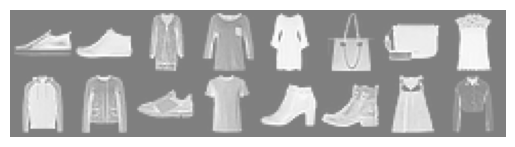

In [ ]:
# get some random training images
dataiter = iter(testloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

In [ ]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class BaseNet(nn.Module):
#     def __init__(self):
#         super(BaseNet, self).__init__()
        
#         # First convolutional layer
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         # Second convolutional layer
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Fully connected layers
#         self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=12)
#         self.relu3 = nn.ReLU()
#         self.fc2 = nn.Linear(in_features=12, out_features=10)
        

#     def forward(self, x):
#         # TODO: define your model here
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)
        
#         # Second convolutional layer
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)
        
#         # Flatten for fully connected layers
#         x = x.view(-1, 12 * 4 * 4)
        
#         # Fully connected layers
#         x = self.fc1(x)
#         x = self.relu3(x)
#         x = self.fc2(x)
#         return x